# Predict the Author of the article ( using LSA) ( scrape the few author articles from project Gutenberg)

In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import spacy
from time import time
%matplotlib inline

In [2]:
# Tools for processing data
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix, make_scorer, adjusted_rand_score, silhouette_score, homogeneity_score, normalized_mutual_info_score

In [3]:
# Classifiers, supervised and unsupervised
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

import warnings
warnings.filterwarnings("ignore")

In [4]:
article = pd.read_csv('gutenberg.csv')

In [11]:
article.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


In [12]:
article.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   50000 non-null  int64  
 1   id           50000 non-null  int64  
 2   title        50000 non-null  object 
 3   publication  50000 non-null  object 
 4   author       43694 non-null  object 
 5   date         50000 non-null  object 
 6   year         50000 non-null  float64
 7   month        50000 non-null  float64
 8   url          0 non-null      float64
 9   content      50000 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 3.8+ MB


Statistical Summary of Article Lengths
count     50000.0000
mean       3853.4537
std        3875.9117
min           1.0000
25%        1682.0000
50%        2853.0000
75%        5045.0000
max      149346.0000
dtype: float64


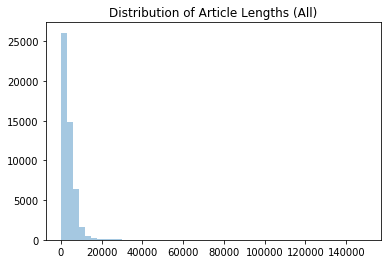

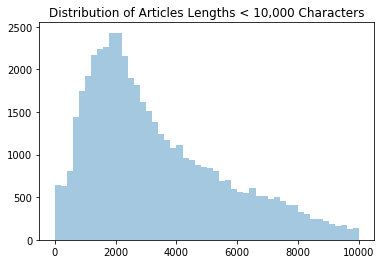

In [5]:
lengths = pd.Series([len(x) for x in article.content])
print('Statistical Summary of Article Lengths')
print(lengths.describe())

sns.distplot(lengths,kde=False)
plt.title('Distribution of Article Lengths (All)')
plt.show()
sns.distplot(lengths[lengths<10000],kde=False)
plt.title('Distribution of Articles Lengths < 10,000 Characters')
plt.show()

In [6]:
# First ten authors with more than X articles
print(article.author.value_counts()[article.author.value_counts()>100][-10:])

Kevin Liptak         119
Eugene Scott         118
Laura Smith-Spark    115
Raheem Kassam        110
Julie Bort           110
Jeremy Berke         109
Eli Watkins          106
Daniella Diaz        104
Oliver Darcy         104
Cartel Chronicles    102
Name: author, dtype: int64


In [6]:
# Make a DataFrame with articles by our chosen authors
# Include author names and article titles.

# Make a list of the 10 chosen author names
names = article.author.value_counts()[article.author.value_counts()>100][-10:].index.tolist()

# DataFrame for articles of all chosen authors
authors_data = pd.DataFrame()
for name in names:
    # Select each author's data
    articles = article[article.author==name][:100][['title','content','author']]
    # Append it to the DataFrame
    authors_data = authors_data.append(articles)

authors_data = authors_data.reset_index().drop('index',1)
    
authors_data.head()

,title,content,author
0,A scramble for quarterbacks in the 2016 NFL Dr...,’ ’ ’ Two NFL teams enter the postseason st...,Scott Davis
1,Rio’s Olympic Stadium has reportedly turned in...,’ ’ ” As is the case with many Rio’s Marac...,Scott Davis
2,The Grizzlies gambled on Chandler Parsons with...,’ ’ ’ Even in an NBA era with a rising sala...,Scott Davis
3,Kevin Love had some simple advice for the Cavs...,’ ’ ’ The Cleveland Cavaliers are with the...,Scott Davis
4,Aaron Rodgers completes another ridiculous Hai...,’ After a slow start to their Wild Card game...,Scott Davis


In [8]:
# Look for duplicates
print('Number of articles:',authors_data.shape[0])
print('Unique articles:',len(np.unique(authors_data.index)))

# Number of authors
print('Unique authors:',len(np.unique(authors_data.author)))
print('')
print('Articles by author:\n')

# Articles counts by author
print(authors_data.author.value_counts())

Number of articles: 1000
Unique articles: 1000
Unique authors: 10

Articles by author:

Jeremy Berke         100
Laura Smith-Spark    100
Raheem Kassam        100
Julie Bort           100
Kevin Liptak         100
Daniella Diaz        100
Oliver Darcy         100
Eli Watkins          100
Cartel Chronicles    100
Eugene Scott         100
Name: author, dtype: int64


Statistical Summary of Article Lengths
count     1000.000000
mean      3004.200000
std       2608.965556
min        106.000000
25%       1645.000000
50%       2356.500000
75%       3522.500000
max      33798.000000
dtype: float64


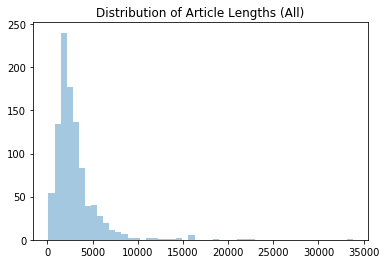

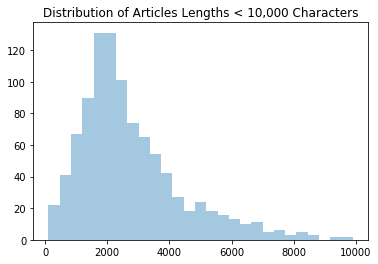

In [7]:
lengths = pd.Series([len(x) for x in authors_data.content])
print('Statistical Summary of Article Lengths')
print(lengths.describe())

sns.distplot(lengths,kde=False)
plt.title('Distribution of Article Lengths (All)')
plt.show()
sns.distplot(lengths[lengths<10000],kde=False)
plt.title('Distribution of Articles Lengths < 10,000 Characters')
plt.show()

In [8]:
#Common bag of words
t0 = time()

# Load spacy NLP object
nlp = spacy.load('en')

# A list to store common words by all authors
common_words = []

# A dictionary to store the spacy_doc object of each author
authors_docs = {}

for name in names:
    # Corpus is all the text written by that author
    corpus = ""
    # Grab all rows of current author, along the 'content' column
    author_content = authors_data.loc[authors_data.author==name,'content']
    
    # Merge all articles in to the author's corpus
    for article in author_content:
        corpus = corpus + article
    # Let Spacy parse the author's body of text
    doc = nlp(corpus)
    
    # Store the doc in the dictionary
    authors_docs[name] = doc
        
    # Filter out punctuation and stop words.
    lemmas = [token.lemma_ for token in doc
                if not token.is_punct and not token.is_stop]
        
    # Return the most common words of that author's corpus.
    bow = [item[0] for item in Counter(lemmas).most_common(1000)]
    
    # Add them to the list of words by all authors.
    for word in bow:
        common_words.append(word)

# Eliminate duplicates
common_words = set(common_words)
    
print('Total number of common words:',len(common_words))
print("done in %0.3fs" % (time() - t0))

OSError: [E050] Can't find model 'en'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.